
preliminary:

	in answering the question:

Should Hedge Funds Pay Greater Attention to Online Retail Investor Communities?

I will provude two methods of analysis
1. empirical analysis of the most popularly traded stocks and ETFs
2. simple trading exercise using WSB portfolio

- should either of these methods prove to show that the return is greater than that of the S&P 500 this is sufficient evidence to suggest that the hedge funds should indeed pay greater attention to online retail investor communnities

(its also worth mentioning the collapse of Melvin Capital hedgefund at the hand of the WSB community)


	further questions i will answer:


- how can i quantify investment advice reliability?
- how can i quantify posts as proactive vs. reactive to the market?
- what is the short/long term performance of the portfolio?
- how can i account for the hype of Jan 2021 in the data?
	 - produce portofolio including/excluding data
- how is my analysis of wallstreetbets retail investors different?
	- both empirical and theoretical analysis
	- use most recent transformers e.g. finBERT

create a simple trading strategy based on the sentiment of the titles in WSB posts.

focusing on the 1 year and 3 year time frames

comparing the portolio to the SPDR S&P500 ETF

		trading algorithm for WSB portfolio:

having identified the companies of highest interest, we can start to prioritise them accordingly, ~20 tickers of the portfolio

calculate the 1 year changea

identify the stocks being traded that day
calculate the sentiment of the posts that day
look at the value of the stock that day

beginning of week:

	look at previous week average sentiment for a stock mentioned
	create a bull / bear ratio given the

	a bull post is positive for the stock
	a bear post is negative for the stock

	if bull/bear ratio positive for stock - long
	if negative - short

	if the ratio -> 1 = very bullish
	if ratio -> 0 = very bearish

	0.5 is therefore a neutral sentiment

	above and below 0.5 must therefore equal some proprotion of the observed sentiment.

during the week:

	if the days average sentiment for the stock is:

	neutral:
		keep remaining position on the stock
	positive:
		increase your exposure
	negative:
		decrease your exposure

end of the week:

	"sell/buy the position"
	calculate total profit
	was the week a success or not

sentiment analysis comparison:
1. modified VADER with additional dictionary
2. finBERT NLP transformer

# Imports

In [9]:
pip install yfinance

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

nltk.download('vader_lexicon')
from datetime import datetime
import spacy as sp
from spacy.matcher import PhraseMatcher, Matcher
from collections import Counter
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import yfinance as yf
import ast

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Functions

In [156]:
def calculate_sentiment(text):
    pol_score = sia.polarity_scores(text)
    if pol_score['compound'] >= 0.05:
        return 1
    elif pol_score['compound'] <= -0.05:
        return -1
    else:
        return 0

def calculate_sentiment_tb(text,compound=True):
    blob = TextBlob(text)

    if compound:
        return blob.polarity

    else:
        if blob.polarity >= 0.05:
            return 1
        elif blob.polarity <= -0.05:
            return -1
        else:
            return 0

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=1022, truncation=True)
    outputs = model(**inputs)
    sentiment_class = outputs.logits.argmax(dim=1).item()
    sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    predicted_sentiment = sentiment_mapping.get(sentiment_class, 'Unknown')
    return predicted_sentiment

# find tickers and company names only from specified list
def find_tickers_and_names(title):
    doc = nlp_freq(title.upper())
    matches = matcher_freq(doc)
    found_items = set([str(doc[match[1]: match[2]]).replace(' ', '') for match in matches])
    tickers_list = set()
    for item in found_items:
        if item in company_names:
            tickers_list.add(company_names[item])
        else:
            tickers_list.add(item)
    for ticker in tickers_list:
        ticker_freq[ticker] += 1
    return '_'.join(tickers_list)

def get_daily_sentiment(dataframe, ticker, sentiment_type='compound'):

    df_ticker = dataframe.copy()[dataframe.orgs.str.contains(ticker)]
    df_ticker_scores = df_ticker.groupby(df_ticker['Date'])[sentiment_type].mean()
    df_ticker_scores = df_ticker_scores.to_frame()
    df_ticker_scores.reset_index(inplace=True)


    return df_ticker_scores

def get_prices(ticker, start, end):
    ticker = yf.Ticker(ticker)
    hist = ticker.history(start=start, end=end)
    hist = hist.reset_index()
    hist['Date'] = hist['Date'].apply(lambda x: x.date())
    hist = hist.set_index("Date")

    return hist[['Open']]

def get_range(ticker):
    gme_list = df.loc[df["orgs"] == ticker]['Date']
    gme_list = gme_list.reset_index(drop=True)
    small = gme_list[len(gme_list)-1]
    big = gme_list[:1][0]

    return(small, big)

def get_change(x):
  day = x['PRICE_day']
  week = x['PRICE_week']

  if day == 0:
    return -1
  try:
    if isinstance(day, dict):
      prices = list(day.values())
      prices2 = list(week.values())

      result = {}

      for key in day:
          if week[key] > day[key]:
              result[key] = 1
          elif week[key] < day[key]:
              result[key] = 0
      return result

    else:
        if week > day:
          return 1
        return 0
  except:
    return -1


def get_rolling_ratio(start):
  rolling_ratio = {}
  for i in portfolio:
    rolling_ratio[i] = [0,0]

  dates = good['Date']
  all_dates = dates.unique()
  first_week = all_dates[start:start+7]

  start_of_week = first_week[0]

  for day in first_week:
    posts = good.loc[good['Date'] == day]
    comps = posts['orgs'].unique()

    for i in comps:
      comp_posts = posts.loc[posts['orgs'] == i]

      try:
        values = comp_posts['PRICE_change'].to_list()[0]

        if "_" in i:
          values = ast.literal_eval(values)

          for c in values.keys():
            if values[c] == 1:
                rolling_ratio[c][0] += 1
            if values[c] == 0:
                rolling_ratio[c][1] += 1

        else:
          if values == 1:
            rolling_ratio[i][0] += 1
          if values == 0:
            rolling_ratio[i][1] += 1

      except:
        continue

  return [start_of_week, rolling_ratio]

# Data Processing

In [5]:
model_name = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# stocks to find,
target_stocks = ['SPY', 'GME', 'AMC', 'TSLA', 'PLTR', 'AAPL', 'AMD', 'BB', 'AMZN', 'NIO', 'NVDA', 'MU', 'RH', 'SNAP', 'NOK', 'SPCE']
company_names = {'S&P': 'SPY', 'GAMESTOP': 'GME', 'AMC': 'AMC', 'TESLA': 'TSLA', 'PALANTIR': 'PLTR', 'APPLE': 'AAPL', 'AMD': 'AMD', 'BLACKBERRY': 'BB',
                 'AMAZON': 'AMZN', 'NIO': 'NIO', 'NVIDIA': 'NVDA', 'MICRON': 'MU', 'RESTORATION': 'RH', 'SNAPCHAT': 'SNAP', 'NOKIA': 'NOK', 'VIRGIN': "SPCE"}

nlp_freq = sp.blank('en')
matcher_freq = PhraseMatcher(nlp_freq.vocab, attr='TEXT')
freq_token_list = [nlp_freq(item) for item in target_stocks + list(company_names)]
matcher_freq.add('Freq Stocks', freq_token_list)

df = pd.read_csv('/content/drive/MyDrive/r_wallstreetbets_posts.csv')
df = df[['title', 'score', 'removed_by', 'total_awards_received',
           'created_utc', 'num_comments']]
df = df.loc[df['score'] >= np.mean(df['score'])]
df = df.reset_index(drop=True)

# put tickers into dataframe
cols = ['symbol', 'id']
tickers = pd.read_csv('/content/drive/MyDrive/ticker.txt',
                      delimiter = "\t", header=None, names = cols)

#df['tb_sentiment'] = df.apply(lambda x: calculate_sentiment_tb(x.title), axis=1)

# some tickers are the same as common words or letters such as NAN, K, AND
tickers['symbol'] = tickers['symbol'].str.upper()
tickers = tickers.dropna()
ticker_freq = Counter()
df['orgs'] = df.apply(lambda x: find_tickers_and_names(x.title), axis=1)
df['Date'] = pd.to_datetime(df['created_utc'],unit='s').dt.date

# need to find all the different stocks being referenced
stocks = []
all = df['orgs'].unique()
for i in all:
  if len(i) == 0:
    continue
  if "_" in i:
    splitup = i.split("_")
    for j in splitup:
      stocks.append(j)
  else:
    stocks.append(i)

stocks = list(pd.Series(stocks).unique())
stock_str = ""
for i in stocks:
  stock_str += i + " "

# create df of stock opens
start = df.Date[len(df)-1]
finish = df.Date[0]
all_stocks = yf.download(stock_str,
                        start=start,
                        end=finish,
                        interval="1d")
dfs = all_stocks['Open']
dfs = dfs.reset_index()


def get_date(x):
  return str(x).split(" ")[0]

dfs['DATE'] = dfs['Date'].apply(lambda x: get_date(x))
dfs = dfs.drop(columns=["Date"])


tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

<ipython-input-5-39ee471cb4a0>:15: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/r_wallstreetbets_posts.csv')
[*********************100%%**********************]  16 of 16 completed


In [7]:
dfs.to_csv('/content/drive/My Drive/stocks_17_04_2024.csv')

In [ ]:
import datetime as dt

def get_week_price(post):
  try:
    if "_" in post['orgs']:
      companies = post['orgs'].split("_")
      prices = {}
      for i in companies:
        date = str(post['Date'] + dt.timedelta(days=7))
        price = list(dfs.loc[dfs['DATE'] == date, i])[0]
        prices[i] = price
      return prices

    else:
      company = post['orgs']
      date = str(post['Date'] + dt.timedelta(days=7))
      price = list(dfs.loc[dfs['DATE'] == date, company])[0]
      return price
  except:
    return 0

def get_day_price(post):
  try:
    if "_" in post['orgs']:
      companies = post['orgs'].split("_")
      prices = {}
      for i in companies:
        date = str(post['Date'])
        price = list(dfs.loc[dfs['DATE'] == date, i])[0]
        prices[i] = price
      return prices

    else:
      company = post['orgs']
      date = str(post['Date'])
      price = list(dfs.loc[dfs['DATE'] == date, company])[0]
      return price
  except:
    return 0

In [ ]:
week_prices = []
prices = []

In [ ]:
for i in range(len(df)):
  prices.append(get_day_price(df.iloc[i]))

In [ ]:
for i in range(len(df)):
  week_prices.append(get_week_price(df.iloc[i]))

In [ ]:
first = pd.Series(week_prices)
second = pd.Series(prices)
df['PRICE_day'] = second
df['PRICE_week'] = first

In [ ]:
changes = []
for i in range(len(df)):
  changes.append(get_change(df.iloc[i]))

In [ ]:
third = pd.Series(changes)
df['PRICE_change'] = third

In [ ]:
df['PRICE_change'].value_counts()

PRICE_change
-1                                         39373
0                                           4778
1                                           3150
{'AMC': 0, 'GME': 0}                         248
{'AMC': 0, 'BB': 0, 'GME': 0, 'NOK': 0}       36
                                           ...  
{'MU': 1, 'RH': 1}                             1
{'AMD': 1, 'SPY': 1}                           1
{'AMD': 0, 'AMZN': 0, 'AAPL': 0}               1
{'AMC': 0, 'AMZN': 0}                          1
{'AMD': 1, 'TSLA': 0, 'AAPL': 0}               1
Name: count, Length: 138, dtype: int64

In [ ]:
df.to_csv('/content/drive/My Drive/df_PRICES_15_04_2024.csv')

# Posts Semantic Processing

In [ ]:
df = pd.read_csv('/content/drive/My Drive/df_PRICES_15_04_2024.csv')
df.head()

,Unnamed: 0,title,score,removed_by,total_awards_received,created_utc,num_comments,tb_sentiment,orgs,Date,PRICE_week,PRICE_day,PRICE_change
0,0,Is XRT is being used to hide GME shorts?,30,deleted,0.0,1613448160,41,0.0,GME,2021-02-16,0,0,-1
1,1,Till Alpha Centauri 💎✋🚀🚀,41,NaN,0.0,1613448113,52,0.0,NaN,2021-02-16,0,0,-1
2,2,Here’s to 2021 boys 🥂,34,NaN,4.0,1613446345,19,0.0,NaN,2021-02-16,0,0,-1
3,3,XRT is being used to hide GME shorts. XRT curr...,219,NaN,7.0,1613443702,434,0.0,GME,2021-02-16,0,0,-1
4,4,is XRT is being used to hide GME shorts?,86,moderator,5.0,1613443199,33,0.0,GME,2021-02-16,0,0,-1


In [ ]:
# find best metric of semantic
# find bull/bear ratio
# use features to predict price change

In [ ]:
new_words = pd.read_csv("/content/drive/MyDrive/vadersemantics.csv")
new_words.head()
words = {}
for i in range(len(new_words)):
  row = new_words.iloc[i]
  words[row['Word']] = row['Score']


In [ ]:
sia = SIA()

sia.lexicon.update(new_words)

In [ ]:
df['sentiment'] = df.apply(lambda x: calculate_sentiment(x.title), axis=1)
df['compound'] = df.apply(lambda x: sia.polarity_scores(x.title)['compound'], axis=1)

In [ ]:
first = df['title'][:5000].apply(lambda x: predict_sentiment(x))

In [ ]:
df['rb_sentiment'] = first

In [ ]:
df['rb_sentiment'].value_counts()

rb_sentiment
Neutral     4334
Negative     368
Positive     298
Name: count, dtype: int64

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [ ]:
text = df['title'][:200].to_list()

In [ ]:
# need to do all of it somehow

In [ ]:
# think that the vader may be the best rn

In [ ]:
inputs = tokenizer(text, padding = True, truncation = True, return_tensors='pt')
outputs = model(**inputs)

In [ ]:
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
model.config.id2label

positive = predictions[:, 0].tolist()
negative = predictions[:, 1].tolist()
neutral = predictions[:, 2].tolist()

table = {'Headline':text, "Positive":positive, "Negative":negative, "Neutral":neutral}
df2 = pd.DataFrame(table, columns = ["Headline", "Positive", "Negative", "Neutral"])

In [ ]:
real = []
def get_real(x):
  if x['Positive'] >= x['Negative']:
    return 1
  return 0

for i in range(len(df2)):
  real.append(get_real(df2.iloc[i]))

df2['polar_sentiment'] = real

In [ ]:
df['finbert']= df2['polar_sentiment']

In [ ]:
test = df.loc[df['PRICE_change'] != "-1"]

In [ ]:
test[['PRICE_change', 'finbert']][:50]

In [ ]:
# might have to simplify data by removing the dicitonary thing, if one of them goes up, they both do, idk

In [ ]:
# make the bull/bear ratio thing now using the semantic finbert
# find number of positive / negative mentions of that company over the week (USING WHOLE DATASET and SMALLER >mean dataset)
# create new dataframe with the day, ticker, and if semantic was positive or negative


# Different Data

In [14]:
test = pd.read_csv('/content/drive/MyDrive/r_wallstreetbets_posts.csv')

<ipython-input-14-70df06a7c3b8>:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv('/content/drive/MyDrive/r_wallstreetbets_posts.csv')


In [ ]:
smaller = test.loc[test['score'] > 1]
(len(smaller) / len(test))*100

15.203469951191522

In [ ]:
cols = ['symbol', 'id']
tickers = pd.read_csv('/content/drive/MyDrive/ticker.txt',
                      delimiter = "\t", header=None, names = cols)
tickers['symbol'] = tickers['symbol'].str.upper()
tickers = tickers.dropna()
ticker_freq = Counter()

smaller['orgs'] = smaller.apply(lambda x: find_tickers_and_names(x.title), axis=1)
smaller = smaller[['orgs', 'score', 'title', 'created_utc']]


In [ ]:
def check_single(x):
  if "_" not in x:
    return x

singles = smaller['orgs'].apply(lambda x: check_single(x))

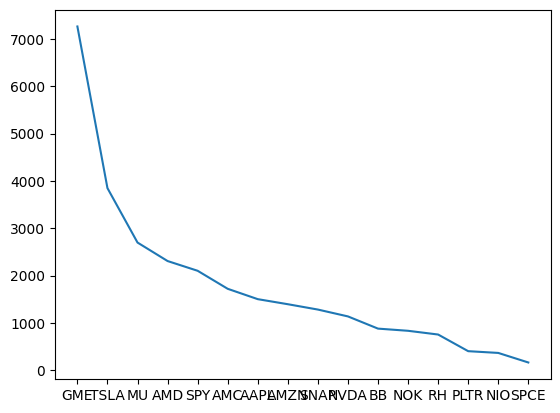

In [ ]:
check = singles.value_counts()
check = check[1:]
plt.plot(check)
plt.show()
# we just have so much more data

In [ ]:
new_words = pd.read_csv("/content/drive/MyDrive/vadersemantics.csv")
new_words.head()
words = {}
for i in range(len(new_words)):
  row = new_words.iloc[i]
  words[row['Word']] = row['Score']

sia = SIA()

sia.lexicon.update(words)

smaller['sentiment'] = smaller.apply(lambda x: calculate_sentiment(x.title), axis=1)
smaller['compound'] = smaller.apply(lambda x: sia.polarity_scores(x.title)['compound'], axis=1)

In [ ]:
smaller.head()

,orgs,score,title,created_utc,sentiment,compound
526,PLTR,11,200K PLTR YOLO.,1613450434,1,0.5267
532,,4,Someone help please 🤯,1613450372,1,0.6124
557,,11,How reliable are Analyst ratings? I collected ...,1613449730,0,0.0000
580,,9,These guys don’t understand...,1613449200,0,0.0000
587,,11,Thoughts on eXRTa General Motor's Economy?,1613449046,0,0.0000


In [ ]:
good = smaller.loc[smaller['orgs'] != ""]
good = good.reset_index(drop=True)
good['Date'] = pd.to_datetime(good['created_utc'],unit='s').dt.date

In [ ]:
week_prices = []
prices = []

for i in range(len(good)):
  prices.append(get_day_price(good.iloc[i]))
for i in range(len(good)):
  week_prices.append(get_week_price(good.iloc[i]))

first = pd.Series(week_prices)
second = pd.Series(prices)
good['PRICE_day'] = second
good['PRICE_week'] = first

changes = []
for i in range(len(good)):
  changes.append(get_change(good.iloc[i]))

third = pd.Series(changes)
good['PRICE_change'] = third

In [ ]:
good.to_csv('/content/drive/My Drive/LARGER_DF_16_04_2024.csv')

# BULL/BEAR RATIO

In [ ]:
good = pd.read_csv('/content/drive/My Drive/LARGER_DF_16_04_2024.csv')

In [18]:
stocks = pd.read_csv('/content/drive/My Drive/stocks_17_04_2024.csv')

In [148]:
cls = ['Date', 'SPY', 'GME', 'AMC', 'TSLA', 'PLTR', 'AAPL', 'AMD', 'BB', 'AMZN', 'NIO', 'NVDA', 'MU', 'RH', 'SNAP', 'NOK', 'SPCE']
portfolio = ['SPY', 'GME', 'AMC', 'TSLA', 'PLTR', 'AAPL', 'AMD', 'BB', 'AMZN', 'NIO', 'NVDA', 'MU', 'RH', 'SNAP', 'NOK', 'SPCE']

In [152]:
positions = pd.DataFrame(columns = cls)
positions

,Date,SPY,GME,AMC,TSLA,PLTR,AAPL,AMD,BB,AMZN,NIO,NVDA,MU,RH,SNAP,NOK,SPCE


In [153]:
week_ratio = {}
for i in portfolio:
  week_ratio[i] = 0

for i in range(0, len(good), 7):
  start = i
  try:
    ratio = get_rolling_ratio(start)
  except:
    break

  date = ratio[0]
  ratio = ratio[1]

  for i in ratio.keys():
    val = ratio[i]
    pos = val[0]
    neg = val[1]

    if neg == 0:
      neg = 1

    bullbear = pos / neg
    week_ratio[i] = bullbear

  week_ratio['Date'] = date

  positions.loc[len(positions)] = week_ratio


In [159]:
positions.to_csv('/content/drive/My Drive/positions_17_04_2024.csv')

In [160]:
positions.head()

,Date,SPY,GME,AMC,TSLA,PLTR,AAPL,AMD,BB,AMZN,NIO,NVDA,MU,RH,SNAP,NOK,SPCE
0,2021-02-16,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,2021-02-08,3.0,0.000000,0.00,1.333333,5.000000,3.0,4.0,2.857143,0.333333,0.0,0.0,0.0,15.0,0.0,0.000000,1.0
2,2021-01-30,1.0,0.148148,0.05,9.000000,0.428571,0.0,0.5,0.000000,3.000000,0.0,0.0,0.0,13.0,0.0,0.027778,7.0
3,2021-01-23,0.0,18.000000,0.00,0.500000,9.000000,0.0,1.0,17.000000,3.000000,1.0,1.0,0.0,0.0,1.0,2.000000,1.0
4,2021-01-16,0.0,14.000000,1.00,1.000000,1.500000,1.0,0.0,6.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.0


In [ ]:
# create a new row which calculates the differenes between each of the rows